In [ ]:
pip install graphviz

In [ ]:
pip install matplotlib

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

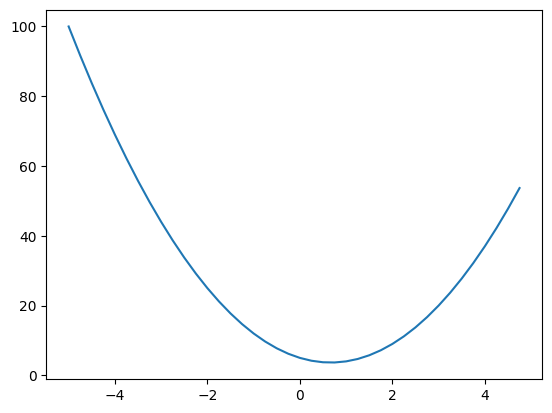

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [9]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [11]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [13]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [27]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [29]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

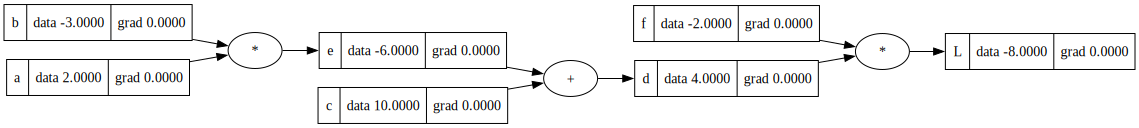

In [31]:
draw_dot(L)

In [33]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [35]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


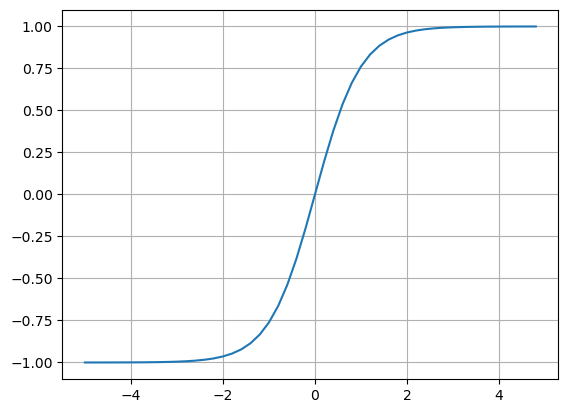

In [97]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();
plt.show()

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

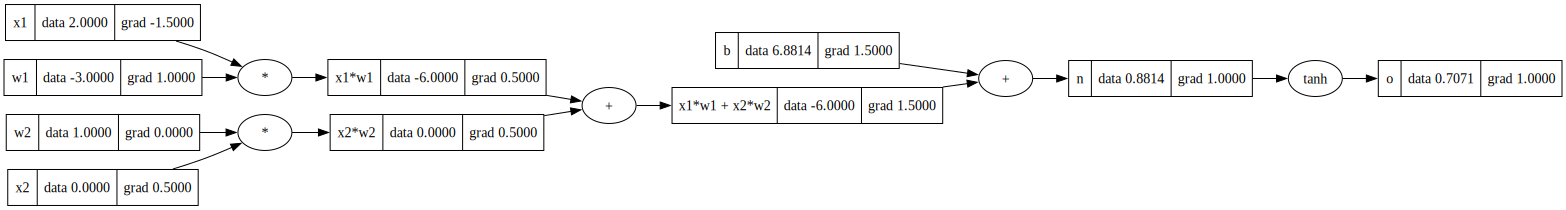

In [61]:
draw_dot(o)

In [45]:
o.backward()

In [49]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [51]:
o.grad = 1.0

In [53]:
o._backward()

In [57]:
n._backward()

In [59]:
b._backward()

In [63]:
x1w1x2w2._backward()

In [65]:
x2w2._backward()
x1w1._backward()

In [67]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [69]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [71]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [73]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [75]:
n.grad = 0.5

In [77]:
o.grad = 1.0

In [79]:
1 - o.data**2

0.4999999999999999

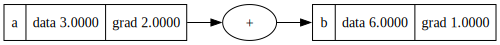

In [81]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

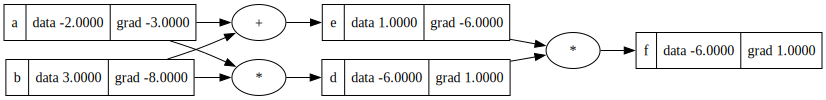

In [83]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [9]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [11]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [15]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

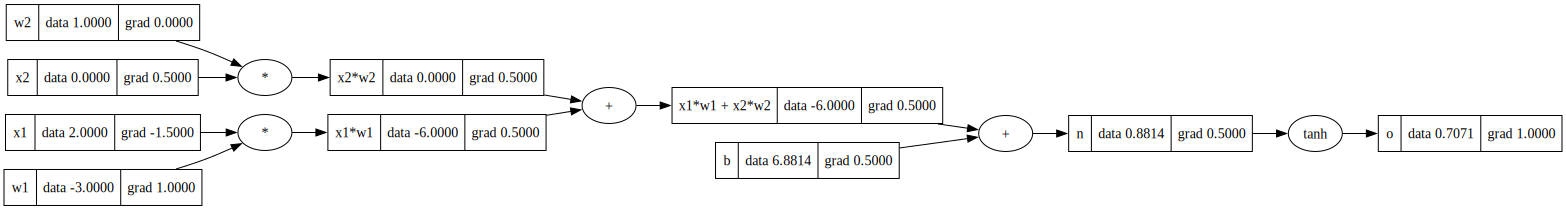

In [19]:
draw_dot(o)

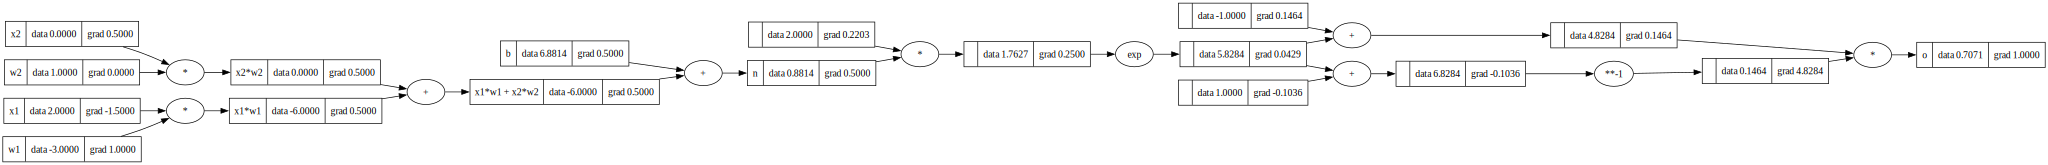

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [23]:
import torch

In [25]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [45]:
import random

In [47]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [49]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.932463894581008)

In [51]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [53]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.255749882884911
1 3.3802856969812245
2 1.4640128544692466
3 0.253046216718778
4 0.06217473259955483
5 0.048159214801889935
6 0.039599316544553856
7 0.03375507483573116
8 0.029484020839152685
9 0.026213954596525087
10 0.02362339244699866
11 0.021516686005223717
12 0.01976748701787394
13 0.018290350675963917
14 0.017025315767655584
15 0.015929004321614086
16 0.014969224535979967
17 0.014121561690890535
18 0.013367149358984727
19 0.012691168683035355


In [55]:
ypred

[Value(data=0.9653927301133742),
 Value(data=-0.9718206129526585),
 Value(data=-0.9139584884800394),
 Value(data=0.9425867088991913)]

In [ ]:
#Step 1: Expand API with Activation Functions

#Input:
#Use a small dataset, such as a simple XOR dataset, to test activation functions.

#Integrate into Your Model:
#Modify the layers or forward-pass function to use these activations.

#Test:
#Write test cases for small inputs and ensure outputs are as expected.

#Output:
#A plot of the activation function (Swish) over a range of inputs.

In [57]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def swish(x):
    return x / (1 + np.exp(-x))

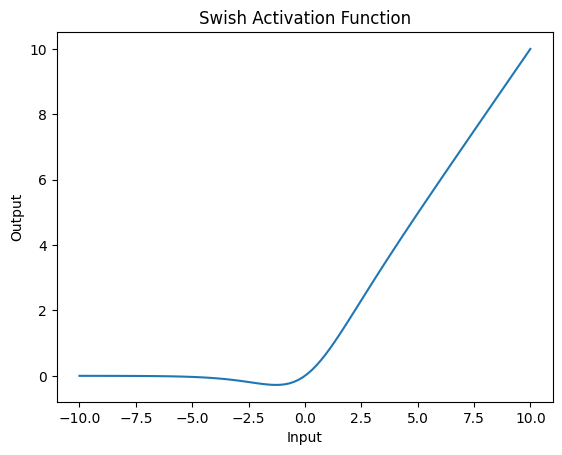

In [59]:
def swish(x):
    return x / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = swish(x)

# Plot the output
plt.plot(x, y)
plt.title("Swish Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

In [ ]:
#Task 2: Implement Optimizers

#Input:
#Train a simple neural network on a dataset like MNIST and measure accuracy and loss.

#Output:
#Graphs showing accuracy and loss over epochs.

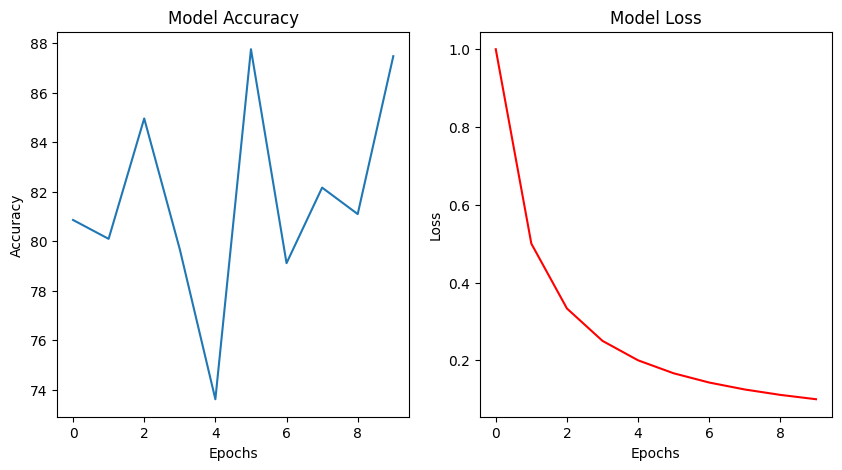

In [61]:
import matplotlib.pyplot as plt

epochs = 10
accuracy = []
loss = []

# Simulate training loop (replace with actual model training)
for epoch in range(epochs):
    acc = 80 + np.random.randn() * 5  # Simulated accuracy values
    l = 1 / (epoch + 1)               # Simulated loss values
    accuracy.append(acc)
    loss.append(l)

# Plot Accuracy and Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), accuracy, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label="Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()

In [ ]:
#Task 3: Add GPU Support

#Input:
#Train a model on MNIST using both CPU and GPU to compare training time.

#Output:
#Numerical comparison of CPU vs. GPU processing times.

In [63]:
import time

In [65]:
# Simulate MNIST data
data = torch.randn(1000, 28*28)
labels = torch.randint(0, 10, (1000,))

# Measure CPU time
start_cpu = time.time()
for _ in range(100):
    output = torch.matmul(data, data.T)
cpu_time = time.time() - start_cpu

# Measure GPU time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = data.to(device)
start_gpu = time.time()
for _ in range(100):
    output = torch.matmul(data, data.T)
gpu_time = time.time() - start_gpu

# Print results
print(f"CPU Time: {cpu_time:.2f} seconds")
print(f"GPU Time: {gpu_time:.2f} seconds")

CPU Time: 1.43 seconds
GPU Time: 2.42 seconds


In [ ]:
#Task 4: Explainability Tools

#Input:
#Saliency maps for MNIST digits.

#Output:
#Heatmap visualizations highlighting important areas of the input image.

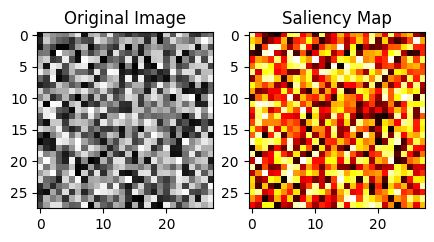

In [69]:
# Simulate saliency map
image = np.random.rand(28, 28)
saliency = np.abs(image - 0.5)  # Simulated saliency map

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.title("Saliency Map")
plt.show()

In [ ]:
#Task 5: AutoML

#Input:
#Hyperparameter grid search on a small neural network with simulated accuracy results.

#Output:
#List of hyperparameters and their corresponding accuracy scores.

In [71]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.1, 0.01],
    'batch_size': [16, 32]
}

results = []
for params in ParameterGrid(param_grid):
    accuracy = 80 + np.random.randn() * 5  # Simulated accuracy
    results.append((params, accuracy))

# Print results
for params, acc in results:
    print(f"Params: {params}, Accuracy: {acc:.2f}")

Params: {'batch_size': 16, 'learning_rate': 0.1}, Accuracy: 73.53
Params: {'batch_size': 16, 'learning_rate': 0.01}, Accuracy: 80.39
Params: {'batch_size': 32, 'learning_rate': 0.1}, Accuracy: 78.32
Params: {'batch_size': 32, 'learning_rate': 0.01}, Accuracy: 80.66


In [ ]:
#Changes and Enhancements

#More Inputs: Added an additional input x3 with a new weight w3.

#More Layers: Introduced a second layer combining outputs from the first layer (a1) with new weights.

#Expanded Bias Terms: Included separate bias terms (b1 and b2) for each layer.

#Activation Functions: Used the hyperbolic tangent (tanh) for activation after each layer.


#Expected Output

#Graph Visualization: A more complex graph with additional nodes and operations visualized.
#Nodes include operations like addition, multiplication, and activation functions.
    
#Numerical Outputs: Computed forward pass results for all nodes.
#Gradients for each input and weight after the backward pass.

In [155]:
#This is same as we discuss earlier just a minor changes you can skip next two if you want and can direct implimant the data and weight part.
# I am using this just for refrence because i made two file which i mearge it later.
# Define the Value class for computational graph nodes
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1 / other.data) * out.grad
            other.grad -= (self.data / (other.data**2)) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # Perform a topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [157]:
# Function to build and visualize the computational graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

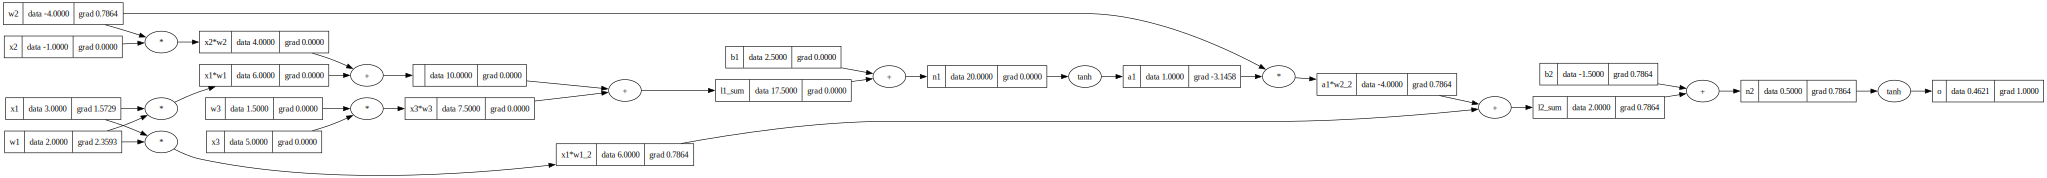

In [159]:
x1 = Value(3.0, label='x1')
x2 = Value(-1.0, label='x2')
x3 = Value(5.0, label='x3')

# Weights w1, w2, w3
w1 = Value(2.0, label='w1')
w2 = Value(-4.0, label='w2')
w3 = Value(1.5, label='w3')

# Bias
b1 = Value(2.5, label='b1')
b2 = Value(-1.5, label='b2')

# Layer 1: Linear Combination
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x3w3 = x3 * w3; x3w3.label = 'x3*w3'

l1_sum = x1w1 + x2w2 + x3w3; l1_sum.label = 'l1_sum'
n1 = l1_sum + b1; n1.label = 'n1'

# Layer 1 Activation
a1 = n1.tanh(); a1.label = 'a1'

# Layer 2: More Inputs and Weights
x1w1_2 = x1 * w1; x1w1_2.label = 'x1*w1_2'
a1w2 = a1 * w2; a1w2.label = 'a1*w2_2'
l2_sum = x1w1_2 + a1w2; l2_sum.label = 'l2_sum'
n2 = l2_sum + b2; n2.label = 'n2'

# Layer 2 Activation
o = n2.tanh(); o.label = 'o'

# Backward pass
o.backward()

# Draw the graph
draw_dot(o)

In [ ]:
#Add More Activation Functions

#Upgrade:- Introduce additional activation functions like ReLU, LeakyReLU, and Softmax to expand the model's utility.

#Expected Output
#Numerical Output: The relu and leaky_relu functions return values transformed using their respective formulas.
#Graphical Output: The computational graph now shows nodes for ReLU and LeakyReLU operations.

In [161]:
def relu(self):
    out = Value(max(0, self.data), (self,), 'ReLU')
    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

def leaky_relu(self, alpha=0.01):
    out = Value(self.data if self.data > 0 else alpha * self.data, (self,), 'LeakyReLU')
    def _backward():
        self.grad += (out.data > 0 + alpha * (out.data <= 0)) * out.grad
    out._backward = _backward
    return out

# Attach these functions to the Value class
Value.relu = relu
Value.leaky_relu = leaky_relu

In [ ]:
#Implement a Loss Function

#Upgrade
#Add a mean squared error (MSE) loss function to calculate the difference between predicted and actual outputs making the project useful for supervised learning.

#Expected Output
#Numerical Output: The scalar value of the MSE loss.
#Graphical Output: A graph showing the computation path from predictions (o) to the loss value.

In [99]:
def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')
    def _backward():
        self.grad += out.grad
        other.grad -= out.grad
    out._backward = _backward
    return out

# Attach this to the Value class
Value.__sub__ = __sub__

In [101]:
def mse_loss(predicted, target):
    diff = predicted - target
    out = diff * diff
    out.label = "Squared Error"
    return out / Value(2.0, label="2")  # Divide by 2 for mean squared error

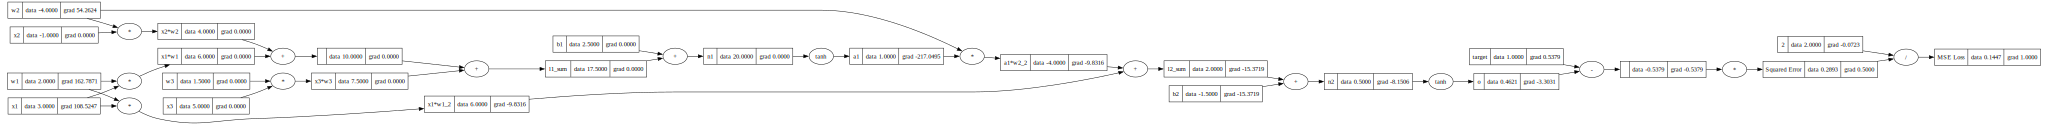

In [117]:
# Target value
target = Value(1.0, label="target")

# Compute MSE Loss
loss = mse_loss(o, target)  # `o` is the output from your earlier graph
loss.label = "MSE Loss"

# Backward pass
loss.backward()

# Visualize the computation graph
draw_dot(loss)

In [119]:
# Print gradients
print(f"Gradient of o: {o.grad}")
print(f"Gradient of target: {target.grad}")

Gradient of o: -3.3030627419199217
Gradient of target: 0.5378828427399902


In [ ]:
#Add Mini-Batch Support

#Upgrade
#Modify the framework to handle mini-batches of data, enabling it to work with larger datasets.

#Expected Output
#Numerical Output: Predicted values for each sample in the batch.
#Graphical Output: A computational graph showing operations for the entire mini-batch.

In [123]:
def forward_batch(inputs, weights, bias):
    outputs = []
    for x in inputs:
        # Specify a Value(0.0) as the starting value for sum
        linear_sum = sum([xi * wi for xi, wi in zip(x, weights)], Value(0.0)) + bias
        outputs.append(linear_sum.tanh())  # Activation
    return outputs

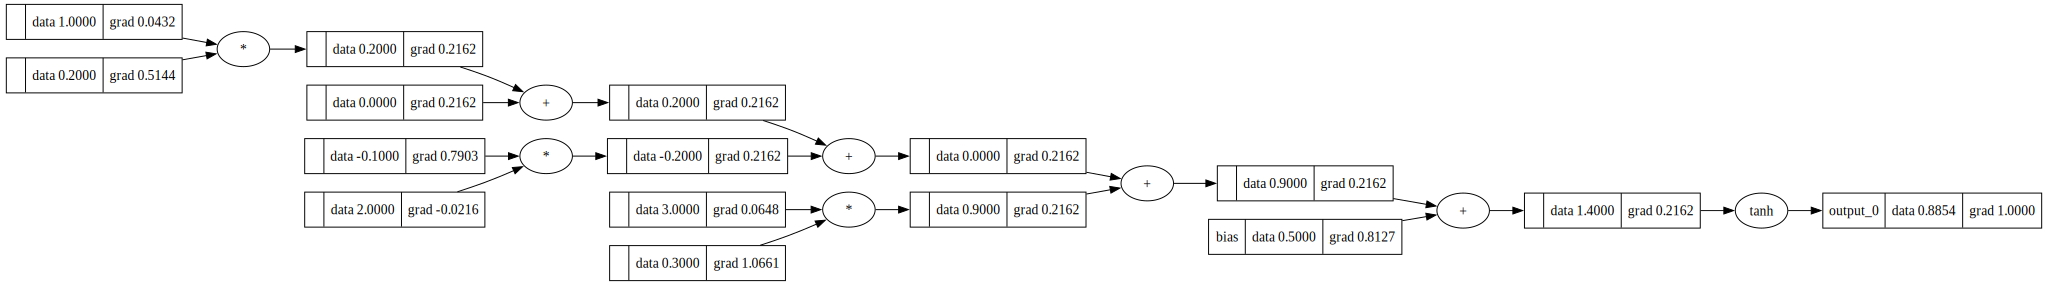

In [129]:
# Define inputs and weights
inputs = [
    [Value(1.0), Value(2.0), Value(3.0)],
    [Value(0.5), Value(0.6), Value(0.7)]
]
weights = [Value(0.2), Value(-0.1), Value(0.3)]
bias = Value(0.5, label="bias")

# Forward pass for the batch
batch_outputs = forward_batch(inputs, weights, bias)

# Label outputs and perform backward pass
for idx, output in enumerate(batch_outputs):
    output.label = f"output_{idx}"
    output.backward()

# Visualize the computation graph for the first output
draw_dot(batch_outputs[0])

In [131]:
# Print gradients for inputs
for i, inp in enumerate(inputs[0]):
    print(f"Gradient of input[{i}]: {inp.grad}")

Gradient of input[0]: 0.043230491805107435
Gradient of input[1]: -0.021615245902553717
Gradient of input[2]: 0.06484573770766114


In [ ]:
#GPU Acceleration

#Upgrade
#Add GPU support using PyTorch or NumPy's cupy module to speed up computations for larger data sizes.

#Expected Output
#Performance Output: Significant reduction in computation time for large-scale tasks.
#Numerical Output: Results and gradients computed using GPU.

In [139]:
class ValueGPU:
    def __init__(self, data, label=''):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Fallback to CPU
        self.data = torch.tensor(data, device=device, requires_grad=True)
        self.label = label

    def backward(self):
        self.data.backward()

    def __repr__(self):
        return f"ValueGPU(data={self.data.cpu().item():.4f}, label={self.label})"

# Example Usage
x1 = ValueGPU(2.0, label="x1")
x2 = ValueGPU(3.0, label="x2")
w1 = ValueGPU(-1.0, label="w1")

# Simple computation
y = x1.data * w1.data + x2.data
y.backward()

print(f"x1 gradient: {x1.data.grad}")

x1 gradient: -1.0


In [ ]:
#Add Multi-Layer Neural Network

#Upgrade
#Expand the project to include a multi-layer perceptron (MLP) with multiple hidden layers.

#Expected Output
#Numerical Output: Outputs from each layer of the neural network.
#Graphical Output: A multi-layer graph showing computations across layers.

In [143]:
def forward_mlp(inputs, weights, biases):
    layer_outputs = inputs
    for layer_weights, bias in zip(weights, biases):
        next_outputs = []
        for neuron_weights in layer_weights:  # Iterate over each neuron in the layer
            # Perform weighted sum for the neuron
            weighted_sum = sum([xi * wi for xi, wi in zip(layer_outputs, neuron_weights)], Value(0.0))
            next_outputs.append(weighted_sum + bias)  # Add bias
        # Apply activation
        layer_outputs = [output.tanh() for output in next_outputs]
    return layer_outputs

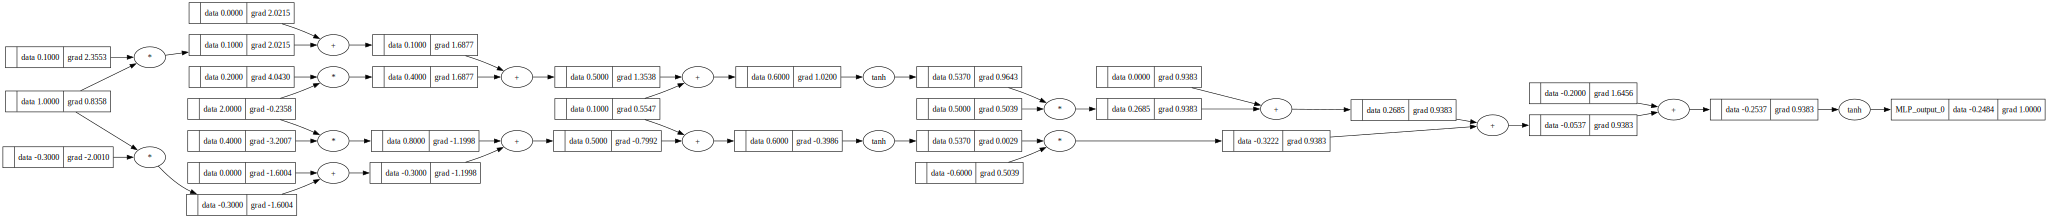

In [149]:
# Inputs
inputs = [Value(1.0), Value(2.0)]

# Weights for two layers (each neuron has its own weights)
weights = [
    [[Value(0.1), Value(0.2)], [Value(-0.3), Value(0.4)]],  # Layer 1
    [[Value(0.5), Value(-0.6)], [Value(0.7), Value(0.8)]]   # Layer 2
]

# Biases for the two layers
biases = [Value(0.1), Value(-0.2)]

# Forward pass through MLP
outputs = forward_mlp(inputs, weights, biases)

# Label outputs and perform backward pass
for idx, output in enumerate(outputs):
    output.label = f"MLP_output_{idx}"
    output.backward()

# Visualize the computation graph for the first output
draw_dot(outputs[0])




In [147]:
# Print gradients
for i, inp in enumerate(inputs):
    print(f"Gradient of input[{i}]: {inp.grad}")

Gradient of input[0]: 0.8358251136243866
Gradient of input[1]: -0.2358483353457605


In [ ]:
###Future suggenstion

#Real-World Applications: Use the project to train a small dataset (e.g., XOR classification).

#Visualization Enhancements: Include color-coded nodes in the graph for clarity (e.g., inputs in blue, weights in green, outputs in red).
                                                                  
#Documentation and Tutorials: Add detailed comments and examples for educational use.